# Procesamiento Adaptativo de Señales Aleatorias
# Trabajo Práctico N°2 - Filtro óptimo
# Notebook #2 - Implementación del filtro
## Grupo 3
* Santiago Arribere
* Matías Francois
* Joaquín Gaytan
* Pablo Scheinfeld

# 1. Señales de prueba
Se buscará medir la respuesta impulsiva de una habitación empleando las siguientes señales de prueba.

* Señal de voz
* Señal de música
* Señal rectangular ($f=100Hz$)
* Barrido lineal de frecuencia ($f_0=20Hz$, $f_1=20kHz$)
* Barrido exponencial de frecuencia ($f_0=20Hz$, $f_1=20kHz$)
* Ruido blanco gaussiano ($\mu_N = 0$)

Cada una de estas señales tendrá una duración de diez segundos.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sps
from IPython.display import Audio
from scipy.io import wavfile
from scipy import linalg, hamming
from scipy.fft import fft, fftfreq
from time import time as pytime

In [2]:
base = '..'
record_base = base + '/assets/recorded_sounds/wavs/'
original_base = base + '/assets/test_signals/'
audios_dict = {
    # AudioType: (recorded, original)
    'song': 'darkside.wav',
    'voice': 'whereiam.wav',
    'linear sweep': 'linear.wav',
    'periodic linear sweep': 'multiple_lin.wav',
    'exp sweep': 'exponential.wav',
    'periodic exp sweep': 'multiple_exp.wav',
    'square': 'rectangular.wav',
    'wgn': 'white-noise.wav'
}

In [3]:
# Define samplerate for input signals
samplerate = 44100 # Hz

In [4]:
def print_signal(x, y, title, samplerate=None, color='blue', xlim=None, window='hanning', ylim=None):
    fig, axs = plt.subplots(2, 1, figsize=(25,10))
    fig.suptitle(title, fontsize=20)
    
    # Time plot
    axs[0].grid()
    axs[0].set_xlabel('Time [sec]')
    if (xlim != None):
        if (len(xlim) == 2):
            axs[0].set_xlim(xlim[0],xlim[1])
    axs[0].plot(x, y, color=color)
            
    # Spectrogram plot
    if samplerate != None:
        f, t, Sxx = sps.spectrogram(y, samplerate, window=window, nperseg=256, noverlap=1)
        axs[1].set_ylabel('Frequency [Hz]')
        axs[1].set_xlabel('Time [sec]')
        if (ylim != None):
            if (len(ylim) == 2):
                axs[1].set_ylim(ylim[0],ylim[1])
        axs[1].pcolormesh(t, f, Sxx, shading='gouraud')

In [5]:
# Assuming that response is delayed from the original. (Add exception!)
#
def sync_tracks(_original, response, scurity=500):
    if len(_original) > len(response):
        raise Exception('Response needs to be larger than original signal!')

    diff = len(response)-len(_original)
    # Original signal padding
    original = np.concatenate((_original, np.zeros(diff)))

    # Compute cross-correlation
    xcorr = sps.correlate(response / np.max(response), original / np.max(original), method='fft')

    # Calculate which lag to apply to sync signals
    sync_lag = np.abs((len(xcorr) // 2) - np.argmax(np.abs(xcorr))) - scurity
    return original, np.concatenate((response[sync_lag:], np.zeros(sync_lag)))

In [6]:
# Nuestras funciones 
def get_r_p(original, recorded):
    N = len(original)
    # Calculate r (autocorrelation vector)
    r = sps.correlate(original, original, method='fft',mode='same')[N//2:] / N
    # Calculate p (cross-correlation vector) - Assuming both signals real and same size
    
    p = sps.correlate(recorded, original, method='fft',mode='same')[N//2:] / N
    #p = np.flip(p[:N//2])
    
    s2d = np.var(recorded)
    return r,p,s2d

In [7]:
def get_filter(r, p, M, sigma):
    r_ = r[:M]
    p_ = p[:M]
    wo = linalg.solve_toeplitz(r_, p_, check_finite=False)
    jo = sigma - p_.dot(wo)
    return wo, p_, jo, jo/sigma

In [8]:
def get_estimations(u,d):
    u_f = np.fft.fft(u)
    d_f = np.fft.fft(d)
    
    ##Estimo rx
    r = np.fft.ifft(u_f * u_f.conj()).real
    r = r[:len(u)//2]/len(u)
    ##Estimo p
    p = np.fft.ifft(u_f * d_f.conj()).real
    p = p[len(u)//2:]/len(u)
    p = np.flip(p)

    ##Estimo la energia de d
    s2d = np.var(d)
    return r,p,s2d

In [9]:
# Get best M for linear sweep
order = [(i*(10**j)) for j in range(1,4) for i in range(1,10)] + [10000, 12500, 20000]
errors_dict = {}
best = {'epsilon':1, 'type': None, 'order':None}
for k in audios_dict:
    jo, epsilon  = [], []
    # Get audio files
    o_rate, original = wavfile.read(original_base + audios_dict[k])
    r_rate, recorded = wavfile.read(record_base + audios_dict[k])
    
    original = original / 32767
    recorded = recorded / 32767

    original -= np.mean(original)
    recorded -= np.mean(recorded)
    # Aling both signals
    original_shifted, response_shifted = sync_tracks(original, recorded)
    
    r, p, sigma = get_r_p(original_shifted, response_shifted)
    
    # Get the variance of the desier signal
    for i in order:
        wo,p1, j, e  = get_filter(r, p, i, sigma)
        jo.append(j)
        epsilon.append(e)
        if best['epsilon'] > e:
            best['epsilon'] = e
            best['type'] = k
            best['order'] = i

    errors_dict[k] = {'jo':jo, 'epsilon':epsilon}
    print(f'Fin {k}')

<ipython-input-9-bb49fb0d2330>:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  o_rate, original = wavfile.read(original_base + audios_dict[k])


Fin song
Fin voice
Fin linear sweep
Fin periodic linear sweep
Fin exp sweep
Fin periodic exp sweep
Fin square
Fin wgn


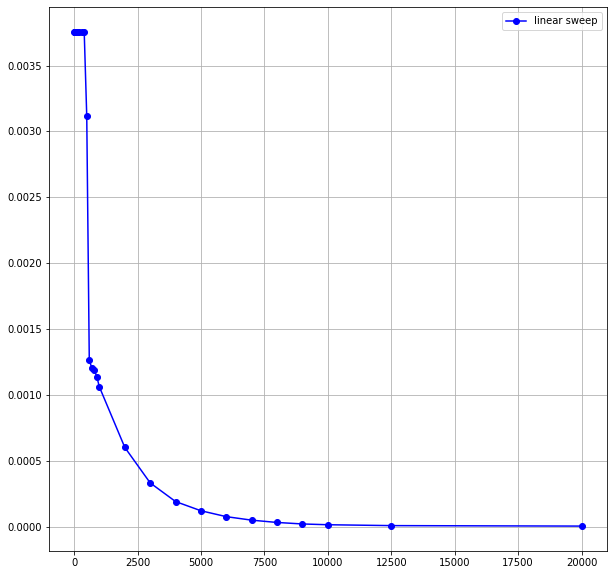

In [10]:
plt.figure(figsize=(10,10))
jo = errors_dict['linear sweep']['jo']
plt.plot(order, jo, label='linear sweep', marker='o', color='blue')
plt.grid(which='both', axis='both')
plt.legend()

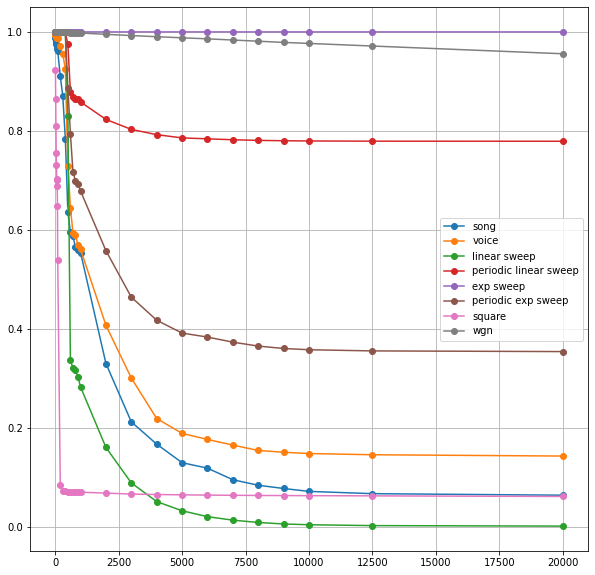

In [107]:
plt.figure(figsize=(10,10))
for k in errors_dict:
    ep = errors_dict[k]['epsilon']
    plt.plot(order, ep, label=k, marker='o')
plt.legend()
plt.grid(which='both', axis='both')
plt.show()

In [12]:
best

{'epsilon': 0.0016887223323752284, 'type': 'linear sweep', 'order': 20000}

## Analisis del mejor

In [13]:
o_rate, original = wavfile.read(original_base + audios_dict[best['type']])
r_rate, recorded = wavfile.read(record_base + audios_dict[best['type']]) 

In [14]:
original = original / 32767
recorded = recorded / 32767

original -= np.mean(original)
recorded -= np.mean(recorded)
# Aling both signals
original_shifted, response_shifted = sync_tracks(original, recorded)

r, p, sigma = get_r_p(original_shifted, response_shifted)
wo,p1, j, e  = get_filter(r, p, best['order'], sigma)

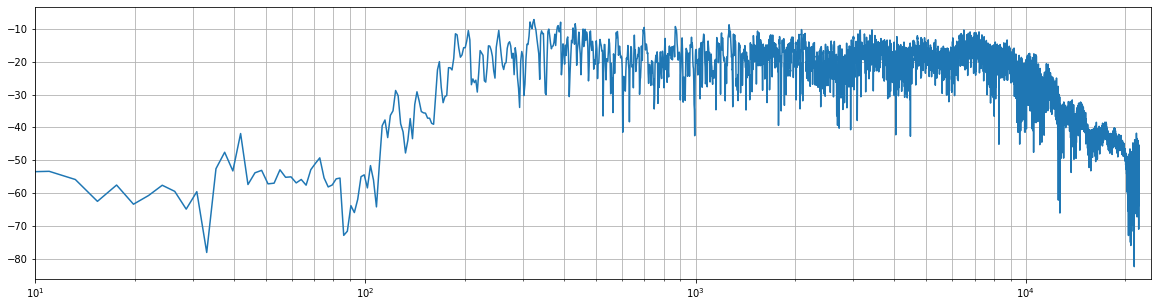

In [15]:
plt.figure(figsize=(20,5))
frec = np.fft.fftfreq(len(wo), 1/r_rate)
plt.semilogx(frec[frec>0], 20*np.log10(np.abs(np.fft.fft(wo)))[frec>0])
plt.xlim(10,24000)
plt.grid(which='both', axis='both')

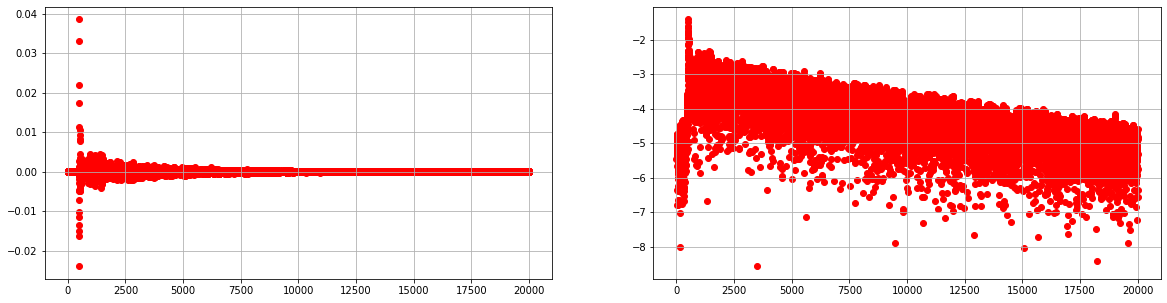

In [16]:
fig, axs = plt.subplots(1,2, figsize=(20,5), sharex=True)
axs[0].grid(which='both', axis='both')
axs[1].grid(which='both', axis='both')
axs[0].scatter(np.arange(len(wo)), wo, color='red')
axs[1].scatter(np.arange(len(wo)), np.log10(np.abs(wo)+1e-10), color='red')

## Test en la cancion

In [17]:
o_rate, original = wavfile.read(original_base + audios_dict['song'])
r_rate, recorded = wavfile.read(record_base + audios_dict['song']) 

output_signal = np.int16(sps.oaconvolve(original, wo))
wavfile.write(base + '/assets/output/filtered_song2.wav', r_rate, output_signal)

<ipython-input-17-ce941b8ce94d>:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  o_rate, original = wavfile.read(original_base + audios_dict['song'])


In [18]:
Audio(base + '/assets/output/filtered_song2.wav')

In [19]:
Audio(record_base + audios_dict['song'])

In [20]:
Audio(original_base + audios_dict['song'])

# Estimación de respuestas impulsivas

In [97]:
def estimate_response(_original, _recorded, M, title):
    
    # Load files
    o_rate, original = wavfile.read(_original)
    r_rate, recorded = wavfile.read(_recorded) 
    
    # Normalize 
    original = original / 32767
    recorded = recorded / 32767

    # Substract mean
    original -= np.mean(original)
    recorded -= np.mean(recorded)
    
    # Aling both signals
    original_shifted, response_shifted = sync_tracks(original, recorded)
    
    # Estimate r, p and sigma^2
    r, p, sigma = get_r_p(original_shifted, response_shifted)
    
    # Estimate filter impulse response
    wo, p1, j, e  = get_filter(r, p, M, sigma)
    
    # Plot estimation
    fig, axs = plt.subplots(2, 1, figsize=(25,10))
    
    fig.suptitle(title, fontsize=25)
    
    # Plot impulse response
    axs[0].grid(which='both', axis='both')
    axs[0].set_xlabel('Lags',fontsize=10)
    axs[0].set_title('Impulsive response estimation', fontsize=15, color='red')
    axs[0].scatter(np.arange(len(wo)), wo, color='red')

    # Compute and plot FFT
    freq = np.fft.fftfreq(len(wo), 1/r_rate)
    axs[1].set_title('Frequency response estimation', fontsize=15, color='blue')
    axs[1].set_xlim(10,24000)
    axs[1].grid(which='both', axis='both')
    axs[1].set_xlabel('Frequency [Hz]', fontsize=10)
    axs[1].set_ylabel('Magnitude [dB]', fontsize=10)
    axs[1].semilogx(freq[freq>0], 20*np.log10(np.abs(np.fft.fft(wo)))[freq>0], color='blue')

## Fragmento de canción

<ipython-input-97-e8a488b7fb58>:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  o_rate, original = wavfile.read(_original)


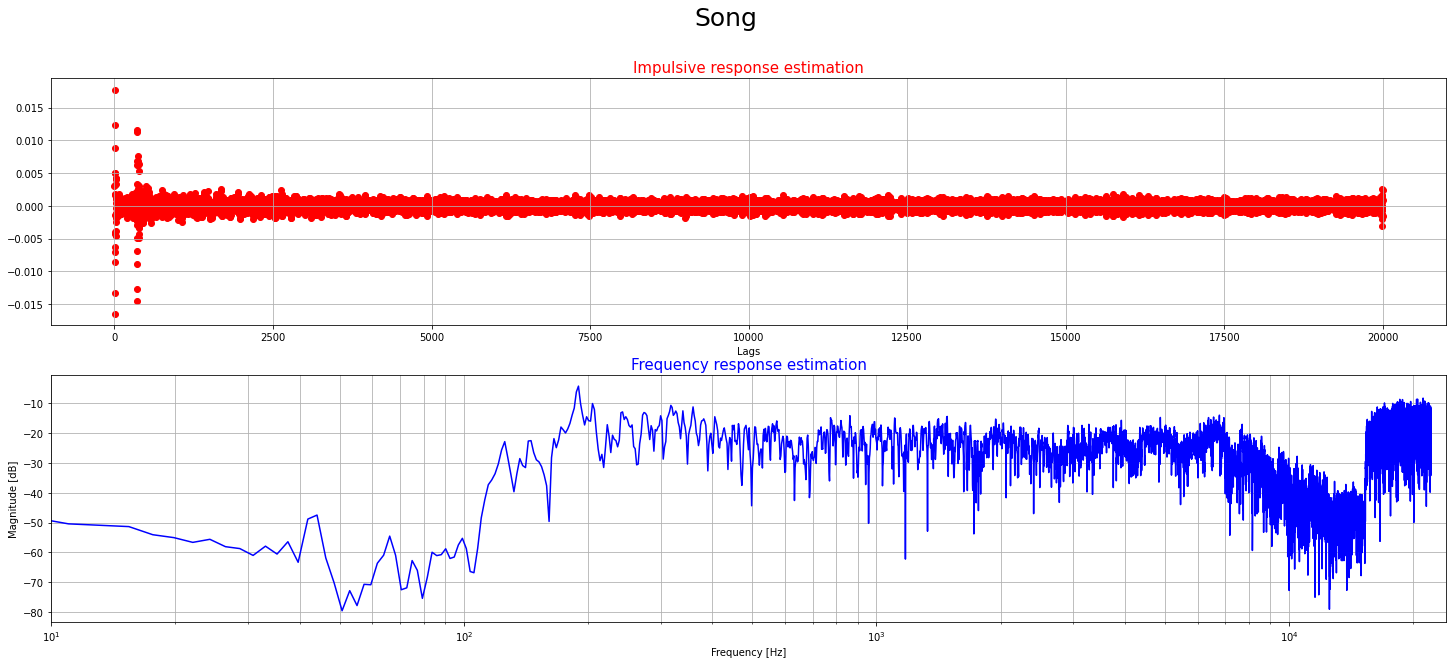

In [98]:
estimate_response(original_base + audios_dict['song'], record_base + audios_dict['song'], 20000, 'Song')

## Señal de voz

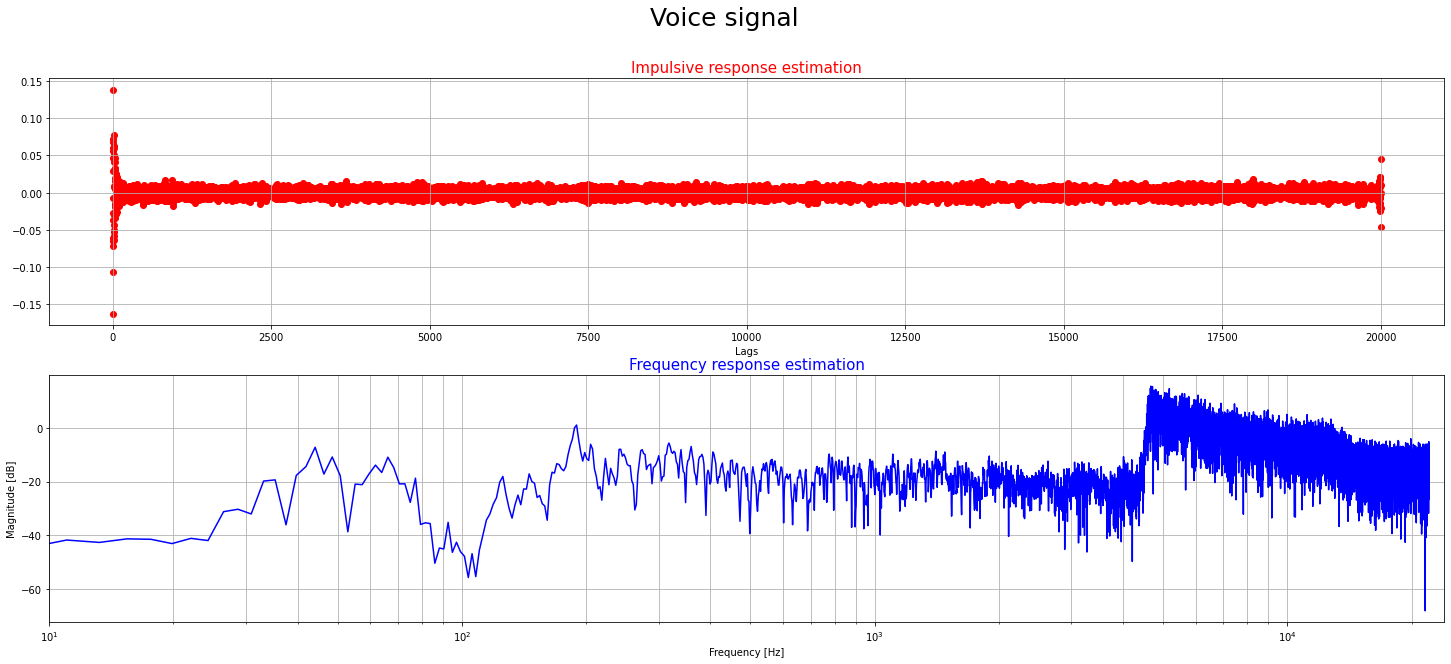

In [101]:
estimate_response(original_base + audios_dict['voice'], record_base + audios_dict['voice'], 20000, 'Voice signal')

## Señal rectangular

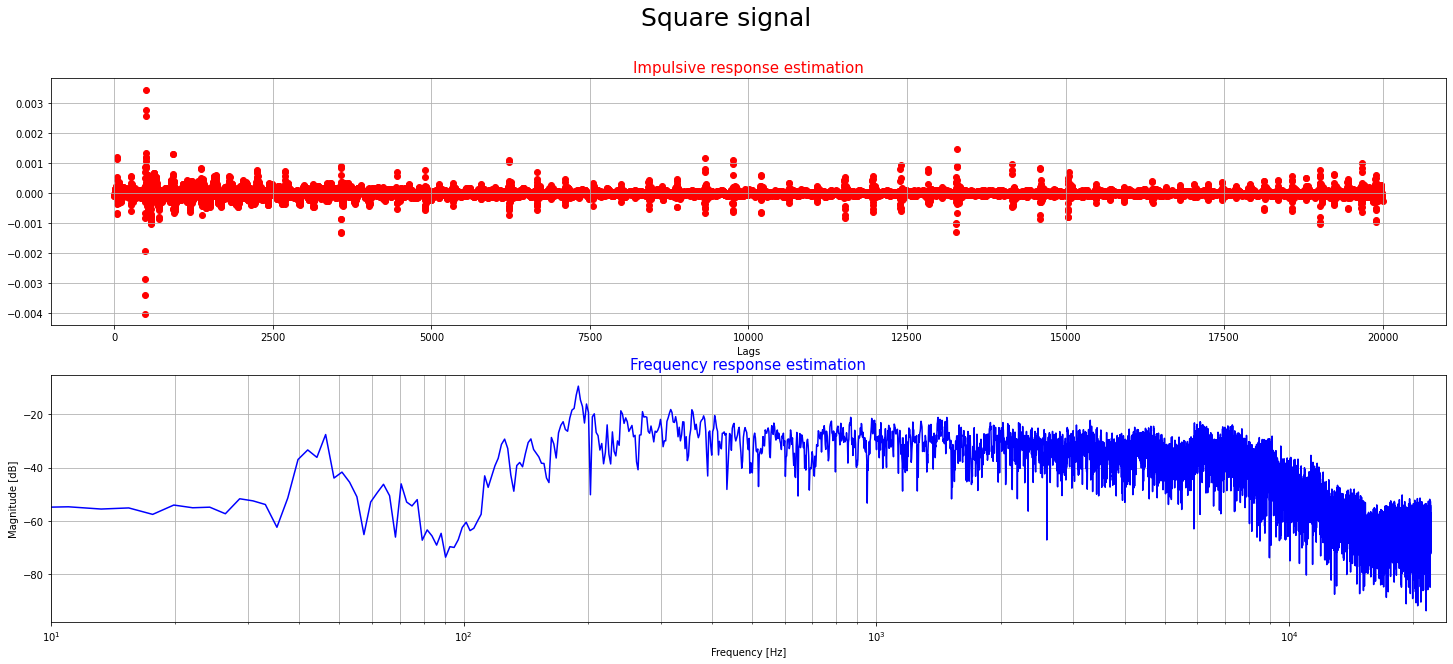

In [102]:
estimate_response(original_base + audios_dict['square'], record_base + audios_dict['square'], 20000, 'Square signal')

## Barrido lineal en frecuencia

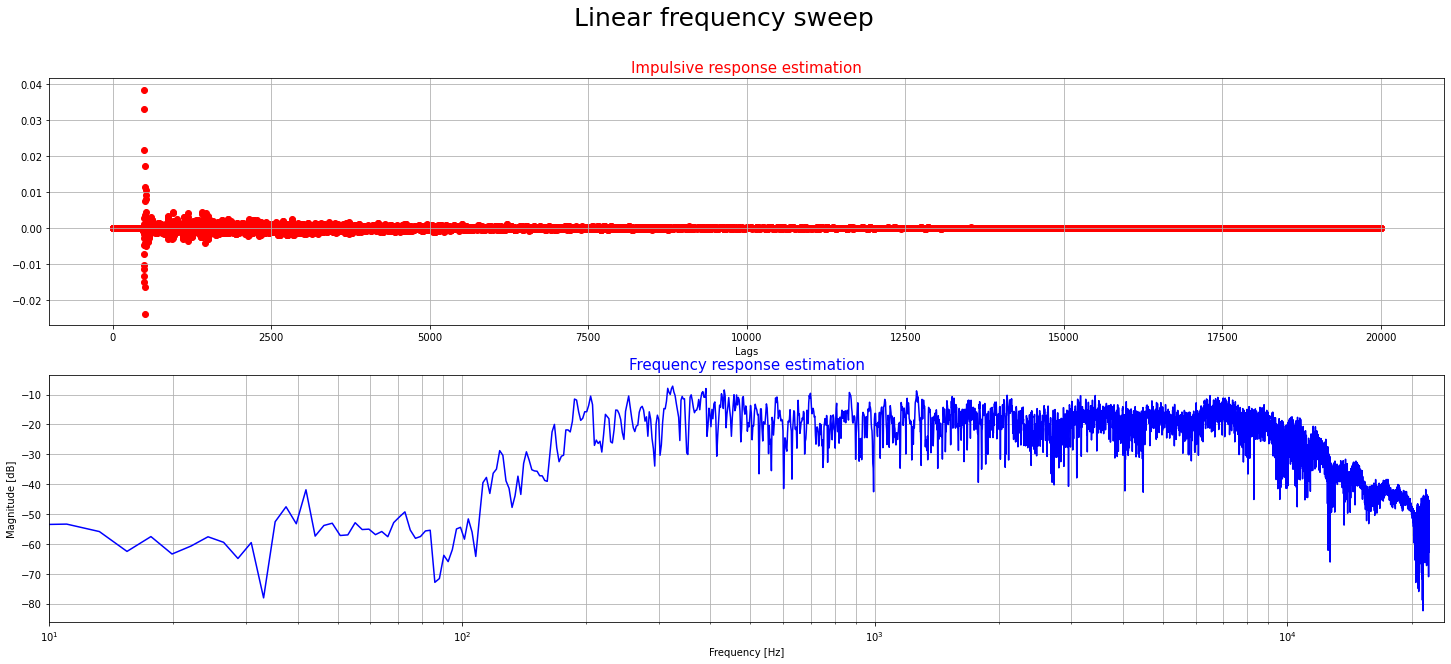

In [103]:
estimate_response(original_base + audios_dict['linear sweep'], record_base + audios_dict['linear sweep'], 20000, 'Linear frequency sweep')

## Barrido exponencial en frecuencia

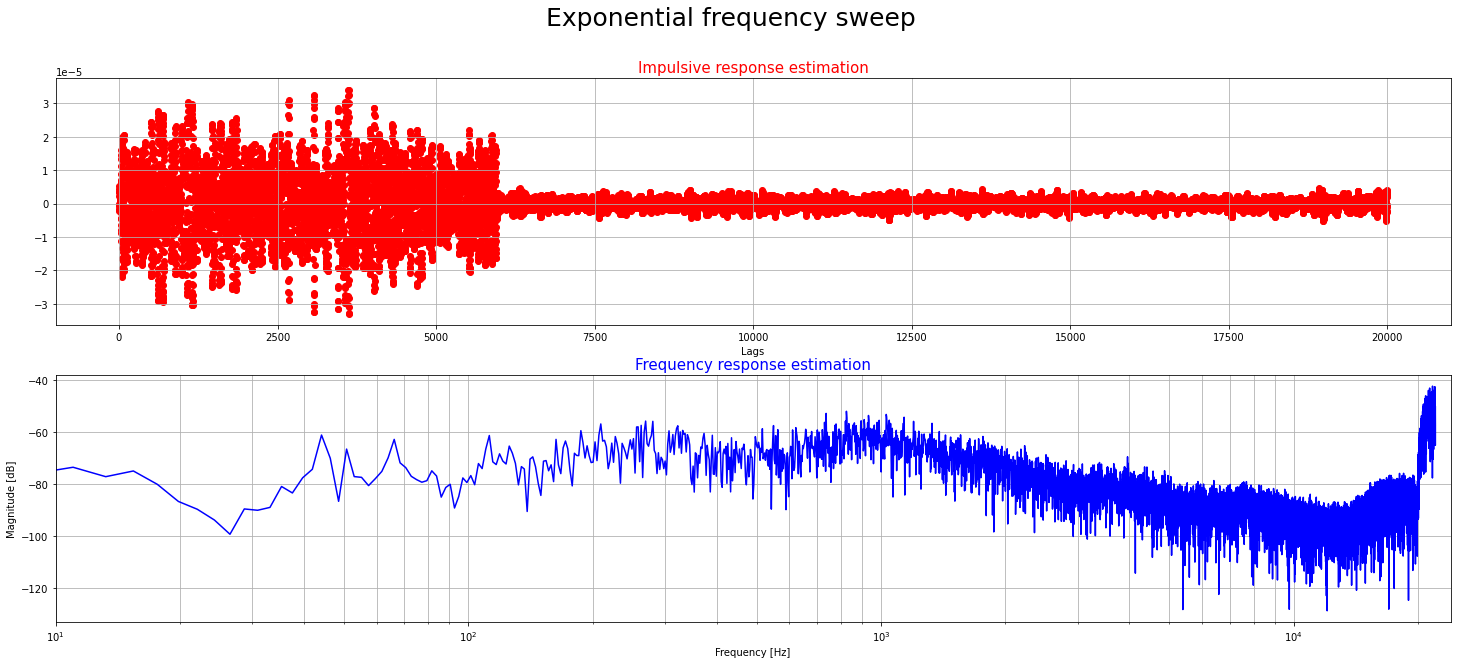

In [104]:
estimate_response(original_base + audios_dict['exp sweep'], record_base + audios_dict['exp sweep'], 20000, 'Exponential frequency sweep')

## Ruido blanco gaussiano

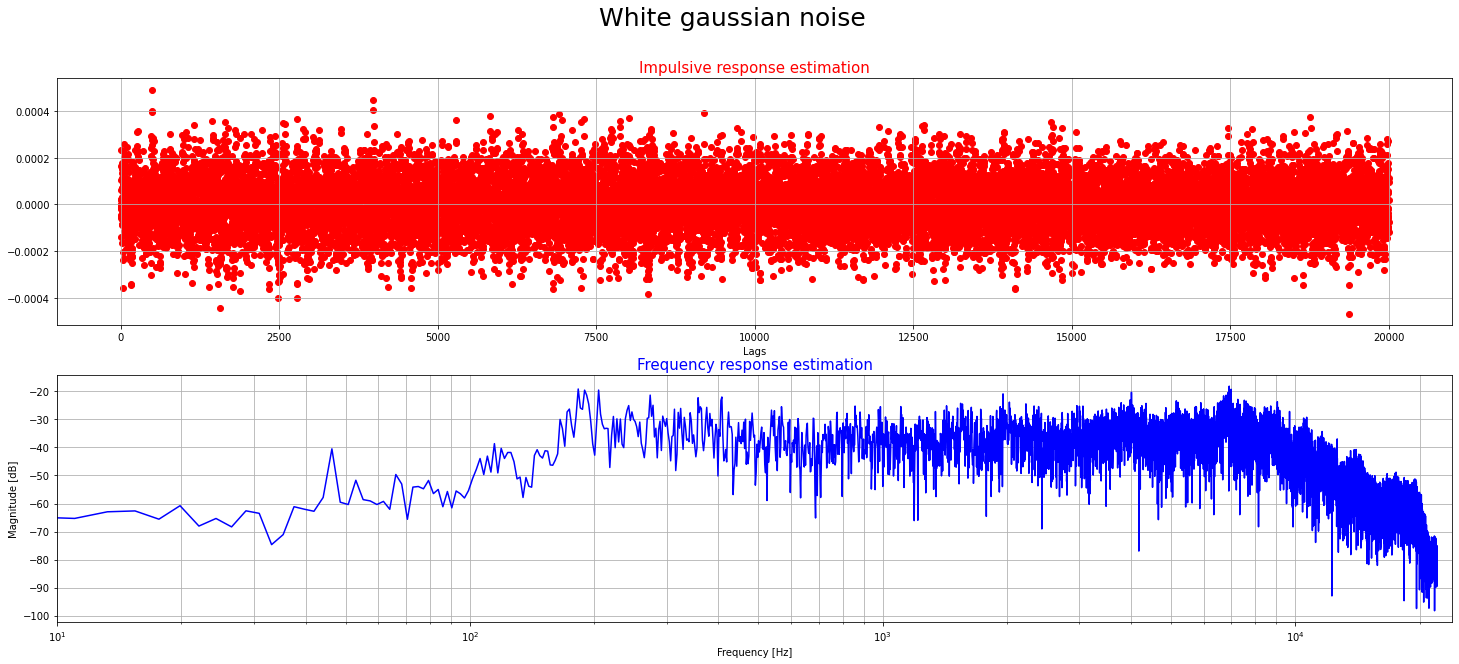

In [105]:
estimate_response(original_base + audios_dict['wgn'], record_base + audios_dict['wgn'], 20000, 'White gaussian noise')